In [ ]:
"""
This code calculates Trip Length Frequencies. 

Inputs  -   People stayPoints File

Output  -   Trip lenght frequency dataframe stored in "extTripsDist_df",
            "intTripsDist_df" for all people
            and also the trip lenght frequencies for each person stored in two 
            dicts, namely "extTripsDistById" and "intTripsDistById"
            
            intTrips means trips within a zone and extTrips indicates the trips
            between zones.
"""

# Tune Multithreading Options

In [1]:
"""
This Part can tune Multi threading

n_workers = Number of CPU cores
memory_limit = limitation of memory for each worker

Becareful about choosing number of workers some time its better to reduce number of workers due to memory limitations

Tune partitioning or number of partitions can help multi threading process and may reduce memory overheading

"""




from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=6, 
                       threads_per_worker=2,
                       memory_limit='4GB')
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:3841 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 12 Memory: 24.00 GB


# Import Libraries

In [3]:

import pandas as pd 
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import dask.dataframe as dd


# Prepairing Dataset

In [81]:
stayPoints = dd.read_csv(r'E:\Arshad\Thesis\Datasets\parameter change\New folder\500m\500m.csv', parse_dates=['Date_Time'] , blocksize='500KB') # Stay Points extracted by "Stay Point Extraction" Code 

#stayPoints = stayPoints.repartition(npartitions=5)
#for weekends u have to import weekends file by add a filtere here and filter these data by days
#stayPoints = stayPoints[(stayPoints['Date_Time'].dt.day_name() != 'Friday') & (stayPoints['Date_Time'].dt.day_name() != 'Thursday')]  #weekday
#stayPoints = stayPoints[(stayPoints['Date_Time'].dt.day_name() == 'Friday') & (stayPoints['Date_Time'].dt.day_name() == 'Thursday')]   #weekend
stays_byID = stayPoints.groupby(by=['ID'])


In [82]:
def triplength(stays_byID):
    
    curIdExtTripsDist = [] # Between Different Zones
    curIdIntTripsDist = [] # Within a Zone
    curIdHometowork = []
    currIdHome = stays_byID[stays_byID.Purpose=='Home'].head(1)
    #counter += 1
    
    df = pd.DataFrame(stays_byID['Date_Time'])
    curIdDays = pd.to_datetime(df['Date_Time'].dt.normalize().unique()) + pd.Timedelta(3,unit='H')
    
    # for i in pd.date_range(start='2019-07-29 3:00:00',periods=31,freq='D'): # Loop over different days of a person ????? Loop over all days. We should make it more efficient
    #     curDayOfId = curIdStays.loc[(curIdStays['Date_Time']>=i) & (curIdStays['Date_Time']<=i+pd.Timedelta(1,unit='D'))]
    for i in curIdDays:
        # curDayOfId = curIdStays.loc[(curIdStays['Date_Time']>=i) & (curIdStays['Date_Time']<=i+pd.Timedelta(1,unit='D'))]
        curDayOfId = stays_byID[(stays_byID['Date_Time']>=i) & (stays_byID['Date_Time'] <= i+ pd.Timedelta(1,unit='D'))]
        if len(curDayOfId != 0):   # ?????? Ignore the days in which the person has no data. ???? It's not efficient. 
            if (stays_byID.iloc[0]['Purpose'] == 'Other') or (stays_byID.iloc[0]['Purpose'] == 'Work'): # Check if the person's home has been found for the current day (Start of the day). If not, insert the home to the start of the day.
                curDayOfId = pd.concat([currIdHome, curDayOfId]) # ?????? reset index 
                        
            if (curDayOfId.iloc[-1]['Purpose'] == 'Other') or (curDayOfId.iloc[-1]['Purpose'] == 'Work'): # Check if the person's home has been found for the current day (End of the day). If not, insert the home to the end of the day.
                curDayOfId = pd.concat([curDayOfId, currIdHome]) # ?????? reset index 
                
            for j1 in range(curDayOfId.shape[0]-1): # ??????? Here we should exclude the successive stay points with the same LatLong to make the code faster 
                if curDayOfId.iloc[j1]['Lat'] != curDayOfId.iloc[j1+1]['Lat'] or curDayOfId.iloc[j1]['Long'] != curDayOfId.iloc[j1+1]['Long']:
                    tripDistance = geodesic(curDayOfId.iloc[j1][['Lat','Long']], curDayOfId.iloc[j1+1][['Lat','Long']]).meters
                    if curDayOfId.iloc[j1]['manategh'] != curDayOfId.iloc[j1+1]['manategh']:
                        curIdExtTripsDist.append(tripDistance)
                    if curDayOfId.iloc[j1]['manategh'] == curDayOfId.iloc[j1+1]['manategh']:
                        curIdIntTripsDist.append(tripDistance)
                    if (curDayOfId.iloc[j1]['Purpose'] == 'Home' or curDayOfId.iloc[j1+1]['Purpose'] == 'Work') and (curDayOfId.iloc[j1+1]['Purpose'] == 'Home' or curDayOfId.iloc[j1]['Purpose'] == 'Work'):
                        tripDistanceworkhome = geodesic(curDayOfId.iloc[j1][['Lat','Long']], curDayOfId.iloc[j1+1][['Lat','Long']]).meters
                        curIdHometowork.append([tripDistanceworkhome,currIdHome.manategh.values[0]])
    
    curIdworkhomedist_df = pd.DataFrame(curIdHometowork, columns=['Trip_length_H2W','Homeloc'])                   
    curIdExtTripsDist_df = pd.DataFrame(curIdExtTripsDist, columns=['Trip_length_external'])
    curIdIntTripsDist_df = pd.DataFrame(curIdIntTripsDist, columns=['Trip_length_internal'])
    #curIdExtTripsDist_df['ID'] = id_
    data = pd.concat([curIdworkhomedist_df,curIdExtTripsDist_df,curIdIntTripsDist_df] )
    data['ID1'] = currIdHome.ID.values[0]
    #curIdIntTripsDist_df['ID'] = id_
    #curIdworkhomedist_df['ID'] = id_

    #extTripsDistById['{}'.format(id_)] = curIdExtTripsDist_df
    #intTripsDistById['{}'.format(id_)] = curIdIntTripsDist_df
    #homeworkdist['{}'.format(id_)] = curIdworkhomedist_df
    return data

# calculate

In [83]:
r = stays_byID.apply(triplength,meta={'Trip_length_H2W':'float','Homeloc':'int','Trip_length_external':'float','Trip_length_internal':'float','ID1':'int'})

# External Trips for each ID

In [111]:
extTrips = r.groupby('ID1')['Trip_length_external'].mean()/1000

# Internal Trips for each ID

In [112]:

intTrips = r.groupby(by=['ID1'])['Trip_length_internal'].mean()/1000
intTrips = intTrips.dropna()

# Home to work distance

In [113]:
datacut_H2W = r[['ID1','Homeloc','Trip_length_H2W']].dropna(subset=['Trip_length_H2W'])
H2W_ = datacut_H2W.groupby(['ID1']).mean()
H2W_f = H2W_.groupby('Homeloc').mean()/1000

# Move from HDD to Ram

In [114]:
external_trips,internal_trip,Home2work= dd.compute(extTrips,intTrips,H2W_f)

# Plotting

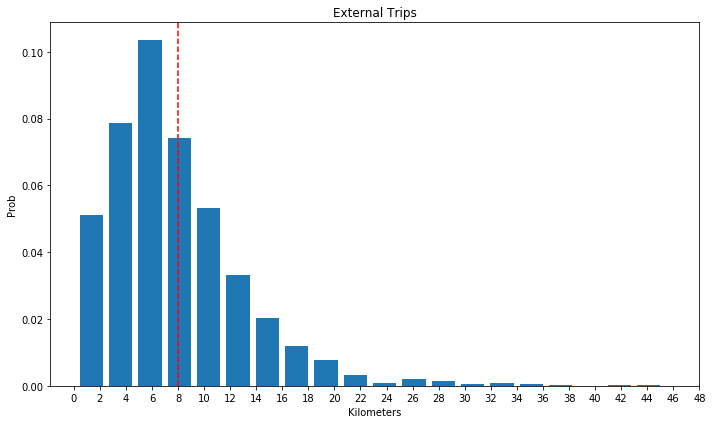

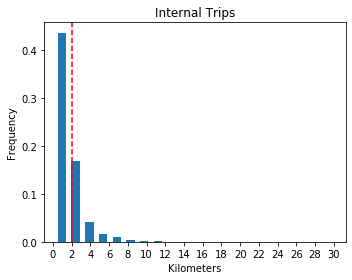

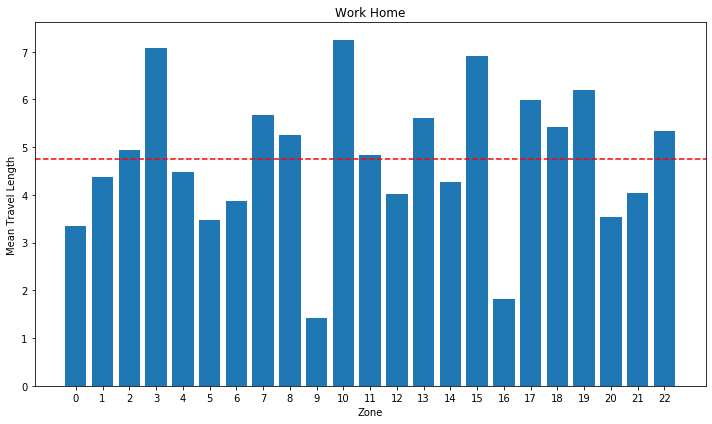

In [138]:
#External Trips
plt.figure(figsize=(10,6))
#extTrips = extTripsDist_df.groupby(by=['ID']).mean()/1000
plt.axvline(external_trips.mean(),color='r', linestyle='--')
plt.hist(external_trips,bins=20,histtype='barstacked',width=1.8,density = True)
plt.xticks([i for i in range(0,50,2)])
plt.xlabel('Kilometers')
plt.ylabel('Prob')
plt.title('External Trips')
plt.tight_layout()


#internal Trips
plt.figure(figsize=(5,4))
#intTrips = intTripsDist_df.groupby(by=['ID']).mean()/1000
plt.hist(internal_trip,bins=20,histtype='barstacked',width=0.9,density = True)
plt.axvline(internal_trip.mean(),color='r', linestyle='--')
plt.xticks([i for i in range(0,32,2)])
plt.xlabel('Kilometers')
plt.ylabel('Frequency')
plt.title('Internal Trips')
plt.tight_layout()



#Home to Works trip length
plt.figure(figsize=(10,6))
#rr = homeworkdist_df.groupby('Homeloc').mean()['Trip_length']/1000
plt.bar(Home2work.index.values,Home2work['Trip_length_H2W'])
plt.xticks(range(0,23))
plt.axhline(Home2work.mean().values[0],color='r', linestyle='--')
plt.xlabel('Zone')
plt.ylabel('Mean Travel Length')
plt.title('Work Home')
plt.tight_layout()


